# Лабораторная работа 2. Решающие деревья и случайные леса.

ФИО: Иванов Сергей Максимович

Группа: 317

In [1]:
import numpy as np

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

In [3]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

### I. Решающие деревья своими руками
#### Задача 1.
В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__1__

Реализуйте следующую функцию:

In [4]:
def find_best_split(feature_vector, target_vector):
    thresholds = np.unique(feature_vector)[1:]
    
    R = len(feature_vector)
    inside = feature_vector[:, np.newaxis] < thresholds[np.newaxis, :]
    R_left = inside.sum(axis=0)
    R_right = R - R_left
    
    p1_left = (inside * target_vector[:, np.newaxis]).sum(axis=0) / R_left
    p1_right = (np.logical_not(inside) * target_vector[:, np.newaxis]).sum(axis=0) / R_right
    p0_left = 1 - p1_left
    p0_right = 1 - p1_right
    
    ginis = (- R_left * (1 - p1_left**2 - p0_left**2) - R_right * (1 - p1_right**2 - p0_right**2)) / R
    
    return thresholds, ginis, thresholds[ginis.argmax()], ginis.max()

Параметры:
* feature_vector: вещественнозначный вектор значений признака (np.array)
* target_vector: вектор классов объектов (np.array). len(feature_vector)==len(target_vector).

Возвращаемые значения:
* thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно разделить на две различные подвыборки, или поддерева (np.array)
* ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds. (np.array, len(ginis)==len(thresholds))
* оптимальный порог (число)
* оптимальное значение критерия Джини (число)

Под критерием Джини здесь подразумевается следующая функция:
$$Q(R) = -\frac {|R_l|}{|R|}H(R_l) -\frac {|R_r|}{|R|}H(R_r),$$
$R$ - множество объектов, $R_l$ и $R_r$ - объекты, попавшие в левое и правое поддерево, $H(R) = 1-p_1^2-p_0^2$, $p_1$, $p_0$ - доля объектов класса 1 и 0 соответственно.

Указания:
* Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
* За наличие в функции циклов балл будет снижен. Векторизуйте! :)

__2__
Загрузите таблицу [students.csv](https://drive.google.com/file/d/0B2zoFVYw1rN3a0d0Zm43TzQ4aUU/view?usp=sharing) (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах,а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог - значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака - класс" для всех пяти признаков.

In [66]:
ST = pd.read_csv("students.csv")
ST.head()

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,0
1,0.08,0.08,0.10,0.24,0.90,1
2,0.06,0.06,0.05,0.25,0.33,0
3,0.10,0.10,0.15,0.65,0.30,1
4,0.08,0.08,0.08,0.98,0.24,0


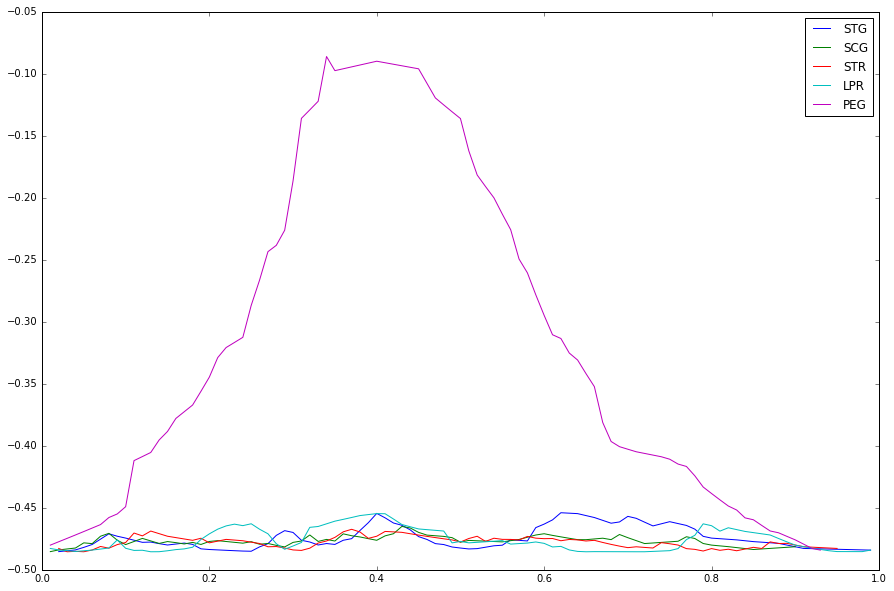

In [77]:
for name in ["STG", "SCG", "STR", "LPR", "PEG"]:
    thr, ginis, opt_thr, opt_gini = find_best_split(ST[name], ST[" UNS"])
    plt.plot(thr, ginis, label=name)

plt.legend()
plt.show()

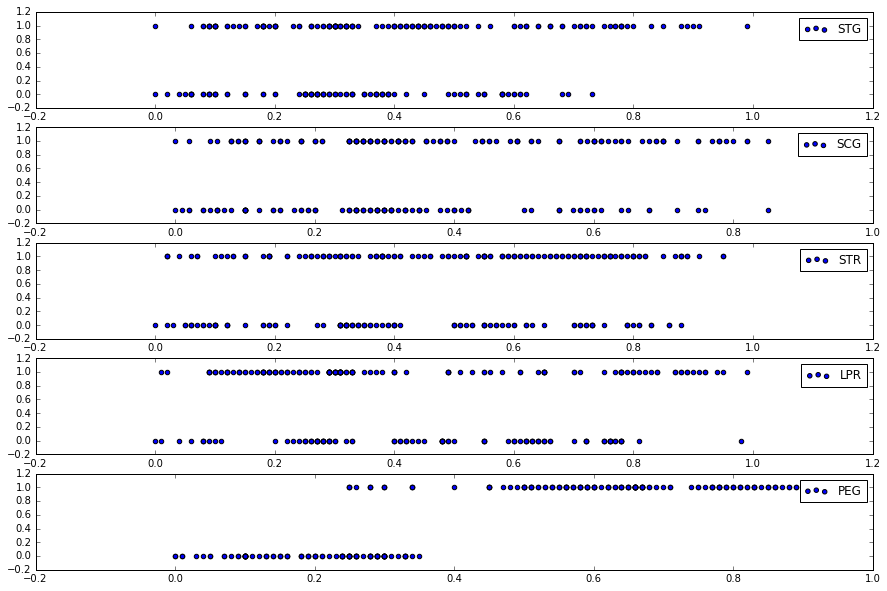

In [87]:
for i, name in enumerate(["STG", "SCG", "STR", "LPR", "PEG"]):
    plt.subplot(511 + i)
    plt.scatter(ST[name], ST[" UNS"], label=name)
    plt.legend()

plt.show()

__3__

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

Ответ:
PEG. Да, на scatter-графике отчётливо видно, что при значении PEG больше 0.4 класс всегда 1, а при меньших почти всегда 0.

Для PEG-а кривая - выпуклая функция, достигающая максимума в некоторой точке оптимального разделяющего порога, а на неоптимальных краях сводящаяся к -0.5. Для "плохих" признаков, где разделить сложно, кривая близка к -0.5 и примерно постоянна.

__4__

Реализуйте класс для обучения решающих деревьев. Мы не будем усложнять класс множеством параметров, как в sklearn. Требования к классу:
* Единственный параметр дерева - вектор, задающий типы признаков: если в позиции i стоит 0, то с признаком номер i нужно работать как с вещественным, если 1 - как с категориальным.
* Чтобы классификатор "распознавался" функциями sklearn, необходимо наследовать его от BaseEstimator. 
* У класса должно быть реализовано два метода: fit и predict. Метод fit принимает на вход двумерный np.array - матрицу объекты-признаки и одномерный вектор ответов y, внутри метода происходит обучение дерева. Метод predict принимает на вход двумерную матрицу объекты-признаки (np.array) и возвращает вектор предсказанных классов (одномерный np.array) для всех объектов.
* Построение дерева должно осуществляться согласно базовому жадному алгоритму. Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу. Ответ в листе: класс объектов, находящихся в нем. Для категориальных признаков необходимо выполнить преобразование, описанное на [семинаре](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem04_trees.pdf) в разделе "Учет категориальных признаков".

Далее будут даны рекомендации по реализации решающего дерева. Им следовать необязательно: например, вы можете использовать свою структуру для хранения дерева.
* Дерево можно хранить в виде сложенных списков. Каждая внутренняя вершина дерева - список node длины 4: node[0] хранит индекс признака, по которому в данной вершине делается разбиение, node[1] - порог для разбиения, если i-й признак вещественный, и множество значений признака, с которыми объект попадает в левое поддерево, если i-й признак категориальный, node[2] - левое поддерево (список) и node[3] - правое поддерево (список). В листьях node состоит из единственного элемента - ответа, возвращаемого в этом листе. Пример простого дерева, разделяющего выборку по нулевому признаку по порогу 5 на два листа, возвращающих класс 0 и 1: [0, 5, [0], [1]]. Если в левом поддереве корня выполнять разделение по 1-му признаку по порогу 7: [0, 5, [1, 7, [0], [1]], [1]].
* Внутри функции fit определяется рекурсивная функция fit_node(subX, suby, node), принимающая матрицу объекты-признаки subX и ответы на этих объектах suby, а также ссылку на пустой список node - вершину, в которой необходимо выполнить разбиение на две подвыборки. Функция fit_node должна заполнить этот список вызовами node.append(.....). Если suby состоит из одинаковых значений, нужно добавить к node это значение и выйти. Иначе выполнить перебор по всем признакам: для каждого признака с помощью функции find_best_split найти наилучшее разбиение и выбрать признак, дающий максимальное значение критерия Джини. Для категориальных признаков нужно выполнить специальное преобразование (см. семинар). Вершину нужно заполнить индексом выбранного признака, порогом или множеством значений (задающих разбиение), а затем рекурсивно вызвать fit_node для левого и правого поддерева.
* Внутри функции predict также определяется рекурсивная функция predict_node(x, node), принимающая один объект и вершину. Она проверяет, является ли node листом (это можно определить по длине списка), если да - возвращает node[0], т. е. класс, задаваемый этим листом. Иначе функция определяет, к какому поддереву относится объект, и рекурсивно вызывает себя для этого поддерева.
* В процессе тестирования кода может оказаться, что рекурсивные вызовы повторяются бесконечно. Так происходит, если в одно из поддеревьев попадает пустая подвыборка. Этого быть не должно: пороги, при которых все объекты попадают в одно поддерево, не рассматриваются (см. указания к функции find_best_split).
* Дерево должно давать единичную долю верных ответов на обучающей выборке.
* Протестировать, правильно ли выполняется преобразование категориальных признаков, можно на простой синтетической выборке с одним категориальным признаком, по которому объекты идеально делятся на два класса, и при этом такого эффекта нельзя достичь установкой порога на этот признак.

In [5]:
from sklearn.base import BaseEstimator

In [6]:
### Шаблон класса, удовлетворяющего требованиям
### тфу, сначала заполнил этот шаблон, а потом долго думал, что ещё за "дерево, следующее рекомендациям"
### потом дошло, что это два различных каркаса... ну ок)))
class DecisionTree(BaseEstimator):
    def __init__(self, types=[], all_categorial = False, all_real = True):
        self.types = types
        self.all_categorial = all_categorial and len(types) == 0
        self.all_real = all_real and len(types) == 0

    def fit(self, X, y):
        def fit_node(subX, subY):
            if subY.sum() == 0:
                return (0,)
            elif subY.sum() == len(subY):
                return (1,)
            
            optimal_feature = 0
            optimal_threshold = 0
            optimal_gini = -1
            
            for i in range(subX.shape[1]):
                if self.types[i] == 0:
                    if len(np.unique(subX[:, i])) > 1:
                        thr, ginis, opt_thr, opt_gini = find_best_split(subX[:, i], subY)
                        if opt_gini > optimal_gini:
                            optimal_feature = i
                            optimal_threshold = opt_thr
                            optimal_gini = opt_gini
                else:
                    categories = np.arange(subX[:, i].max() + 1)
                    ranges = subX[:, i][:, np.newaxis] == categories[np.newaxis, :]
                    parts = (ranges * subY[:, np.newaxis]).sum(axis=0) / ranges.sum(axis=0)

                    artificial_feature = parts[subX[:, i]]
                    if len(np.unique(artificial_feature)) > 1:
                        thr, ginis, opt_thr, opt_gini = find_best_split(artificial_feature, subY)
                        if opt_gini > optimal_gini:
                            optimal_feature = i
                            optimal_threshold = parts < opt_thr
                            optimal_gini = opt_gini
            
            if self.types[optimal_feature] == 0:
                return (optimal_feature, optimal_threshold,
                       fit_node(subX[subX[:, optimal_feature] < optimal_threshold], subY[subX[:, optimal_feature] < optimal_threshold]),
                       fit_node(subX[subX[:, optimal_feature] >= optimal_threshold], subY[subX[:, optimal_feature] >= optimal_threshold]))
            else:
                return (optimal_feature, optimal_threshold,
                       fit_node(subX[optimal_threshold[subX[:, optimal_feature]]], subY[optimal_threshold[subX[:, optimal_feature]]]),
                       fit_node(subX[np.logical_not(optimal_threshold[subX[:, optimal_feature]])], subY[np.logical_not(optimal_threshold[subX[:, optimal_feature]])]))
        
        if self.all_categorial:
            self.types = np.ones((X.shape[1]))
        elif self.all_real:
            self.types = np.zeros((X.shape[1]))
        
        self.node = fit_node(X, y)
        
    def predict(self, X):
        def predict_node(x, node):
            if len(node) == 1:
                return node[0]
            
            if self.types[node[0]] == 0:
                if x[node[0]] < node[1]:
                    return predict_node(x, node[2])
                else:
                    return predict_node(x, node[3])
            else:
                if x[node[0]] >= len(node[1]) or node[1][x[node[0]]]:
                    return predict_node(x, node[2])
                else:
                    return predict_node(x, node[3])
                
        return np.array([predict_node(X[i], self.node) for i in range(len(X))])

In [42]:
tree = DecisionTree([1])
tree.fit(np.array([[1], [1], [1], [2], [2], [3], [3], [3], [4], [4], [4], [4], [0], [5], [5], [6], [6], [6], [6]]),
         np.array([ 1,   1,   1,   0,   0,   1,   1,   1,   0,   0,   0,   0,   0,   1,   1,   0,   0,   0,   0]))
tree.predict(np.array([[6], [3], [2], [4], [1], [0]]))

array([0, 1, 0, 0, 1, 0])

__5__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец - это целевая переменная (e-edible, p-poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что - классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [56]:
mushrooms = pd.read_csv("mushrooms.csv")
mushrooms.head()    

,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
1,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
2,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
3,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
4,e,x,y,y,t,a,f,c,b,n,...,s,w,w,p,w,o,p,k,n,g


In [57]:
from sklearn.preprocessing import LabelEncoder
for col in mushrooms.columns:
    mushrooms[col] = LabelEncoder().fit_transform(mushrooms[col])
mushrooms.head()

,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
1,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
2,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
3,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1
4,0,5,3,9,1,0,1,0,0,5,...,2,7,7,0,2,1,4,2,2,1


In [58]:
# сортируем грыбочки
from sklearn.utils import shuffle
mushrooms = shuffle(mushrooms)
L = len(mushrooms)

ans = mushrooms["p"]
del mushrooms["p"]

train, train_ans, test, test_ans = mushrooms[:L//2].as_matrix(), ans[:L//2], mushrooms[L//2:].as_matrix(), ans[L//2:]

In [59]:
dtree = DecisionTree(np.ones((len(mushrooms.columns))))
dtree.fit(train, train_ans)
forecast = dtree.predict(test)

print("Accuracy: ", (forecast == test_ans).sum() / len(forecast))

Accuracy:  1.0


__6__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-rac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc - это класс 0, good, vgood - класс 1)
* [nurcery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recom - класс 0, very_recom, priority, spec_prior - класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам - наборы данных, по столбцам - алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scorer=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

In [60]:
from sklearn.cross_validation import cross_val_score as cvs
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier

Results = pd.DataFrame(columns=["AllReal", "AllCategorial", "OneHot", "Sklearn"], index=["Mushrooms Samba", "tic-rac-toe", "cars", "nurcery"])

In [61]:
oh_mushrooms = OneHotEncoder(sparse=False).fit_transform(mushrooms)

In [62]:
Results.ix["Mushrooms Samba", "AllReal"] = cvs(DecisionTree(), mushrooms.as_matrix(), ans, scoring = make_scorer(accuracy_score), cv=10).mean()
Results.ix["Mushrooms Samba", "AllCategorial"] = cvs(DecisionTree(all_categorial = True), mushrooms.as_matrix(), ans, scoring = make_scorer(accuracy_score), cv=10).mean()
Results.ix["Mushrooms Samba", "OneHot"] = cvs(DecisionTree(), oh_mushrooms, ans, scoring = make_scorer(accuracy_score), cv=10).mean()
Results.ix["Mushrooms Samba", "Sklearn"] = cvs(DecisionTreeClassifier(), mushrooms, ans, scoring = make_scorer(accuracy_score), cv=10).mean()

In [63]:
tic_tac = pd.read_csv("tic-tac-toe.csv")
tic_tac.head()

,x,x.1,x.2,x.3,o,o.1,x.4,o.2,o.3,positive
0,x,x,x,x,o,o,o,x,o,positive
1,x,x,x,x,o,o,o,o,x,positive
2,x,x,x,x,o,o,o,b,b,positive
3,x,x,x,x,o,o,b,o,b,positive
4,x,x,x,x,o,o,b,b,o,positive


In [64]:
for col in tic_tac.columns:
    tic_tac[col] = LabelEncoder().fit_transform(tic_tac[col])
ans = tic_tac["positive"]
del tic_tac["positive"]
oh_tic_tac = OneHotEncoder(sparse=False).fit_transform(tic_tac)

In [65]:
Results.ix["tic-rac-toe", "AllReal"] = cvs(DecisionTree(), tic_tac.as_matrix(), ans, scoring = make_scorer(accuracy_score), cv=10).mean()
Results.ix["tic-rac-toe", "AllCategorial"] = cvs(DecisionTree(all_categorial = True), tic_tac.as_matrix(), ans, scoring = make_scorer(accuracy_score), cv=10).mean()
Results.ix["tic-rac-toe", "OneHot"] = cvs(DecisionTree(), oh_tic_tac, ans, scoring = make_scorer(accuracy_score), cv=10).mean()
Results.ix["tic-rac-toe", "Sklearn"] = cvs(DecisionTreeClassifier(), tic_tac, ans, scoring = make_scorer(accuracy_score), cv=10).mean()

In [66]:
cars = pd.read_csv("cars.csv")
cars.head(15)

,vhigh,vhigh.1,2,2.1,small,low,unacc
0,vhigh,vhigh,2,2,small,med,unacc
1,vhigh,vhigh,2,2,small,high,unacc
2,vhigh,vhigh,2,2,med,low,unacc
3,vhigh,vhigh,2,2,med,med,unacc
4,vhigh,vhigh,2,2,med,high,unacc
5,vhigh,vhigh,2,2,big,low,unacc
6,vhigh,vhigh,2,2,big,med,unacc
7,vhigh,vhigh,2,2,big,high,unacc
8,vhigh,vhigh,2,4,small,low,unacc
9,vhigh,vhigh,2,4,small,med,unacc


In [67]:
cars["unacc"][cars["unacc"] == "acc"] = 0
cars["unacc"][cars["unacc"] == "good"] = 1
cars["unacc"][cars["unacc"] == "vgood"] = 1
cars["unacc"][cars["unacc"] == "unacc"] = 0
for col in cars.columns:
    cars[col] = LabelEncoder().fit_transform(cars[col])
ans = cars["unacc"]
del cars["unacc"]
oh_cars = OneHotEncoder(sparse=False).fit_transform(cars)

In [68]:
Results.ix["cars", "AllReal"] = cvs(DecisionTree(), cars.as_matrix(), ans, scoring = make_scorer(accuracy_score), cv=10).mean()
Results.ix["cars", "AllCategorial"] = cvs(DecisionTree(all_categorial = True), cars.as_matrix(), ans, scoring = make_scorer(accuracy_score), cv=10).mean()
Results.ix["cars", "OneHot"] = cvs(DecisionTree(), oh_cars, ans, scoring = make_scorer(accuracy_score), cv=10).mean()
Results.ix["cars", "Sklearn"] = cvs(DecisionTreeClassifier(), cars, ans, scoring = make_scorer(accuracy_score), cv=10).mean()

In [69]:
nurcery = pd.read_csv("nursery.csv")
nurcery.head(10)

,usual,proper,complete,1,convenient,convenient.1,nonprob,recommended,recommend
0,usual,proper,complete,1,convenient,convenient,nonprob,priority,priority
1,usual,proper,complete,1,convenient,convenient,nonprob,not_recom,not_recom
2,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended,recommend
3,usual,proper,complete,1,convenient,convenient,slightly_prob,priority,priority
4,usual,proper,complete,1,convenient,convenient,slightly_prob,not_recom,not_recom
5,usual,proper,complete,1,convenient,convenient,problematic,recommended,priority
6,usual,proper,complete,1,convenient,convenient,problematic,priority,priority
7,usual,proper,complete,1,convenient,convenient,problematic,not_recom,not_recom
8,usual,proper,complete,1,convenient,inconv,nonprob,recommended,very_recom
9,usual,proper,complete,1,convenient,inconv,nonprob,priority,priority


In [70]:
nurcery["recommend"][nurcery["recommend"] == "recom"] = 0
nurcery["recommend"][nurcery["recommend"] == "recommend"] = 0
nurcery["recommend"][nurcery["recommend"] == "spec_prior"] = 1
nurcery["recommend"][nurcery["recommend"] == "priority"] = 1
nurcery["recommend"][nurcery["recommend"] == "very_recom"] = 1
nurcery["recommend"][nurcery["recommend"] == "not_recom"] = 0
for col in nurcery.columns:
    nurcery[col] = LabelEncoder().fit_transform(nurcery[col])
ans = nurcery["recommend"]
del nurcery["recommend"]
oh_nurcery = OneHotEncoder(sparse=False).fit_transform(nurcery)

In [71]:
Results.ix["nurcery", "AllReal"] = cvs(DecisionTree(), nurcery.as_matrix(), ans, scoring = make_scorer(accuracy_score), cv=10).mean()
Results.ix["nurcery", "AllCategorial"] = cvs(DecisionTree(all_categorial = True), nurcery.as_matrix(), ans, scoring = make_scorer(accuracy_score), cv=10).mean()
Results.ix["nurcery", "OneHot"] = cvs(DecisionTree(), oh_nurcery, ans, scoring = make_scorer(accuracy_score), cv=10).mean()
Results.ix["nurcery", "Sklearn"] = cvs(DecisionTreeClassifier(), nurcery, ans, scoring = make_scorer(accuracy_score), cv=10).mean()

In [55]:
Results

,AllReal,AllCategorial,OneHot,Sklearn
Mushrooms Samba,1,1,1,1
tic-rac-toe,0.467939,0.549265,0.55352,0.721965
cars,0.939693,0.965194,0.921767,0.940955
nurcery,0.999846,0.999923,0.999769,0.999846


__7__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

Ответ: Неодинаково, и эти четыре способа работают по-разному в зависимости от данных. Например, если признак бинарный, рассмотрение его как вещественного или категориального не влияет на построение дерева. Непонятно, что такого волшебного делает sklearn в том же самом DecisionTree с тем же критерием Джини, что так повысил качество на tic-tac-toe-датасете. На остальных датасетах он показывает себя ровненько с остальными, хотя на nurcery и mushrooms у всех и так близко к 1 и достичь особых успехов трудно.

Рассматривать все признаки как вещественные чаще хуже всего, поскольку неявно устанавливается отношение сравнения между категориями, что обычно не соответствует характеру данных. Интересны результаты one-hot-а, работа с которым на полностью обученном дереве примерно соответствует тому, чтобы рассматривать булев куб в многомногомерном пространстве и каждой точке сопоставить, какое значение целевой переменной чаще попадало в неё (или "рядом", если данных по этой точке не было - а где именно рядом, зависит от того, как шло построение!).

Случайностей при полном построении дерева в целом нет, и в точности на одних и тех же данных результат будет один. Однако, следует осторожно относится к структуре датасета. Если он неоднороден, или, например, отсортирован по какому-либо признаку, следует сначала его хорошо пошаффлить, иначе дерево будет строиться на одном подпространстве данных, а предсказывать целевую на другом.

### II. Композиции деревьев
#### Задача 2. Сравнение композиционных методов над решающими деревьями
__8 (1 балл)__

Выполните следующие шаги:
1. Загрузите датасет [winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv) в датафрейм. Последний столбец - целевая переменная (содержит классы).
1. С помощью cross_val_score с cv=3 оцените качество (accuracy) следующих классификаторов:
    * DecisionTreeClassifier
    * BaggingClassifier со 100 деревьями
    * BaggingClassifier со 100 деревьями; каждое дерево обучается только по половине случайно выбранных признаков (см. параметры метода)
    * RandomForestClassifier со 100 деревьями
    
Значение получается шумное, но в целом у вас должно получиться, что качество возрастает с каждым следующим алгоритмом. Этот пример демонстрирует, что RandomForest - это более сложный алгоритм, чем бэггинг и бэггинг со случайными подпространствами. 

In [14]:
wine = pd.read_csv("winequality-red.csv", sep=';')
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [15]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

ans = wine["quality"]
del wine["quality"]

In [34]:
print("DecisionTree: ", cvs(DecisionTreeClassifier(), wine, ans, scoring = make_scorer(accuracy_score), cv=3).mean())
print("BaggingClassifier: ", cvs(BaggingClassifier(n_estimators=100), wine, ans, scoring = make_scorer(accuracy_score), cv=3).mean())
print("BaggingClassifier-half: ", cvs(BaggingClassifier(n_estimators=100, max_features=0.5), wine, ans, scoring = make_scorer(accuracy_score), cv=3).mean())
print("RandomForest: ", cvs(RandomForestClassifier(n_estimators=100), wine, ans, scoring = make_scorer(accuracy_score), cv=3).mean())

DecisionTree:  0.434669672224
BaggingClassifier:  0.545406801422
BaggingClassifier-half:  0.550440708654
RandomForest:  0.566698533346


Достичь желаемого возрастания качества получилось только с пятого запуска. Обычно предавал ожидания BaggingClassifier на половине признаков, выступая хуже бэггинга на всех признаках.

#### Задача 3. Число деревьев в случайном лесе и в градиентном бустинге
В этой задаче мы рассмотрим, переобучаются ли композиционные алгоритмы с увеличением числа деревьев.

__9__

Продолжим работать с набором данных [winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv). Разделите выборку на обучение и контроль с пропорции 7:3, предварительно перемешав объекты. Переберите значения от 100 до 5000 деревьев с шагом 10, посчитайте accuracy на тестовой выборке для каждого числа деревьев и постройте график зависимости качества от числа деревьев.

Рекомендация.

Если каждый раз обучать RandomForest с нуля, придётся обучить в общей сумме $10 + 20 + \ldots + 5000$ деревьев.
Однако, как мы знаем, деревья в случайных лесах строятся независимо и параллельно, поэтому можно обучить всего 5000 деревьев.

Для этого в при создании объекта класса RandomForestClassifier нужно указать в том числе warm_start=True. Затем обучить алгоритм с помощью метода fit, использовать метод predict для классификации. После этого с помощью метода set_params изменить параметр n_estimators. Если к полученному объекту применить метод fit, внутри него будет обучаться только недостающее число деревьев.

Переобучается ли случайный лес с увеличением числа деревьев?

In [38]:
wine = pd.read_csv("winequality-red.csv", sep=';')
# делаем суффле из вина
wine = shuffle(wine)

ans = wine["quality"]
del wine["quality"]
L = int(len(ans) * 0.7)

train, train_ans, test, test_ans = wine[:L], ans[:L], wine[L:], ans[L:]

In [40]:
clf = RandomForestClassifier(n_estimators = 10, warm_start=True)
num_of_trees = np.arange(10, 5000, 10)
qualities = np.ones((len(num_of_trees)))

for i, n in enumerate(num_of_trees):
    clf.set_params(n_estimators = n)
    clf.fit(train, train_ans)
    qualities[i] = accuracy_score(test_ans, clf.predict(test))

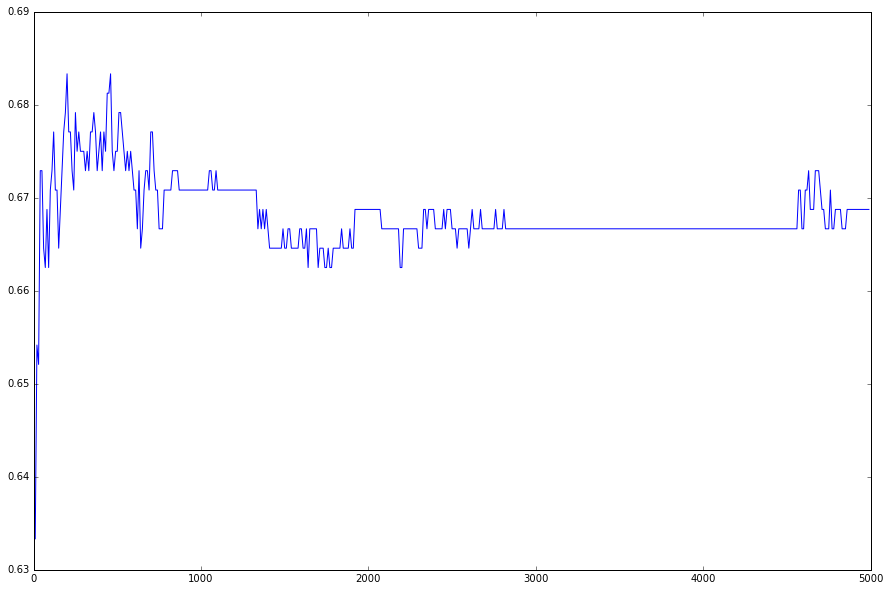

In [41]:
plt.plot(num_of_trees, qualities)
plt.show()

В случае переобучения кривая бы тихонько стремилась к 0.5, но этого не происходит - кривая выходит на асимптоту в районе 0.667. Интересно поведение в районе 50-1000 деревьев, где качество лучше, чем на асимптоте. Следует помнить, что такой результат RF показывает на контроле, а насколько он улавливает общие закономерности в данных - вопрос. 

Здесь вы можете поделиться мыслями о задании.

Не знаю, насколько полезно деревья ручками пилить, но это оказалось не так сложно, как показалось на первый взгляд. Ну хоть без стрижек ручками.

Последнее задание очень напомнило последние задания из первой лабы, там бы совет про warm_start очень бы пригодился, там как-то костляво решал из-за вычислительных ограничений, а тут всё понятно (и мораль вроде та же) - так что первую лабу можно... чуть-чуть постричь.

Вообще, все задания сложнее, чем написать десять строчек, давать позже середины ноября толку как ёжику от новых иголок. Надо лабы к сентябрю сдвигать! И, хотя это намного больше касается прака и машграфа, стригите задания, потому что иначе выходит переобучение.

А здесь — вставить нарисованную вами смешную картинку.

<a><img src="http://www.imageup.ru/img115/2614407/smeshnaya-kartinka.png" border="0"></a>